In [52]:
test_df = pd.read_csv('test_one_hot_encoded_final.csv',  encoding='utf-8')

In [53]:
train_df = pd.read_csv('train_one_hot_encoded_final1.csv',  encoding='utf-8')

In [54]:
# Automatically infer feature columns from a DataFrame, assuming 'log_price' is the target
def get_feature_columns(df, target='log_price'):
    return [col for col in df.columns if col != target]


In [13]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np
import pandas as pd

# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Confidence interval helper
def confidence_interval(scores):
    mean = np.mean(scores)
    std = np.std(scores)
    ci_95 = 1.96 * std / np.sqrt(len(scores))
    return round(mean, 4), round(std, 4), round(mean - ci_95, 4), round(min(mean + ci_95, 1), 4)

# Function to run 10-fold CV with GridSearch for each model
def evaluate_models_with_gridsearch(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    models_and_params = {
        "Ridge Regression": (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
        "Lasso Regression": (Lasso(max_iter=10000), {'alpha': [0.01, 0.1, 1.0]}),
        "Random Forest": (RandomForestRegressor(random_state=42), {'n_estimators': [50, 100], 'max_depth': [10, None]}),
        "XGBoost": (XGBRegressor(objective='reg:squarederror', random_state=42), {'n_estimators': [50, 100], 'max_depth': [3, 6]})
    }

    results = []

    for name, (model, params) in models_and_params.items():
        grid = GridSearchCV(model, params, cv=kf, scoring=rmse_scorer, n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_

        rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=rmse_scorer)
        mae_scores = cross_val_score(best_model, X, y, cv=kf, scoring='neg_mean_absolute_error')
        r2_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')

        rmse_mean, rmse_std, rmse_lower, rmse_upper = confidence_interval(rmse_scores)
        mae_mean, mae_std, mae_lower, mae_upper = confidence_interval(-mae_scores)
        r2_mean, r2_std, r2_lower, r2_upper = confidence_interval(r2_scores)

        results.append({
            "Model": name,
            "Best Params": grid.best_params_,
            "RMSE Mean": rmse_mean,
            "RMSE STD": rmse_std,
            "RMSE 95% CI Lower": rmse_lower,
            "RMSE 95% CI Upper": rmse_upper,
            "MAE Mean": mae_mean,
            "MAE STD": mae_std,
            "MAE 95% CI Lower": mae_lower,
            "MAE 95% CI Upper": mae_upper,
            "R2 Mean": r2_mean,
            "R2 STD": r2_std,
            "R2 95% CI Lower": r2_lower,
            "R2 95% CI Upper": r2_upper
        })

    return pd.DataFrame(results)



In [ ]:
# Assuming you already have your training set
feature_columns = get_feature_columns(train_df)
X = train_df[feature_columns]   # Your selected input features
y = train_df['log_price']       # Target variable


results_df = evaluate_models_with_gridsearch(X, y)
print(results_df)

In [23]:
results_df

,Model,Best Params,RMSE Mean,RMSE STD,RMSE 95% CI Lower,RMSE 95% CI Upper,MAE Mean,MAE STD,MAE 95% CI Lower,MAE 95% CI Upper,R2 Mean,R2 STD,R2 95% CI Lower,R2 95% CI Upper
0,Ridge Regression,{'alpha': 10.0},0.2546,0.0033,0.2526,0.2567,0.2009,0.0032,0.1989,0.2028,0.6324,0.0092,0.6267,0.6381
1,Lasso Regression,{'alpha': 1.0},0.4201,0.0054,0.4168,0.4234,0.3346,0.0053,0.3313,0.3379,-0.0004,0.0004,-0.0007,-0.0001
2,Random Forest,"{'max_depth': 10, 'n_estimators': 50}",0.2467,0.0041,0.2441,0.2493,0.1938,0.0034,0.1917,0.1959,0.6548,0.0121,0.6473,0.6623
3,XGBoost,"{'max_depth': 3, 'n_estimators': 50}",0.2442,0.0035,0.2421,0.2464,0.1922,0.0029,0.1904,0.1940,0.6617,0.0100,0.6555,0.6680


In [58]:
import pandas as pd

def drop_address_related_columns(df):
    """
    Drops 'lat', 'lon', and any columns that start with 'city' or 'district' from the DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: Cleaned DataFrame with address-related fields removed.
    """
    cols_to_drop = ['lat', 'lon', 'log_distance_km']
    cols_to_drop += [col for col in df.columns if col.lower().startswith('city')]
    cols_to_drop += [col for col in df.columns if col.lower().startswith('district')]

    return df.drop(columns=cols_to_drop, errors='ignore')


In [59]:
train_df_dropped = drop_address_related_columns(train_df)

In [60]:
test_df_dropped = drop_address_related_columns(test_df)

In [32]:
test_df_dropped .columns

Index(['new_construction', 'elevator', 'floors_in_the_building',
       'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor',
       'duration_encoded', 'children_are_welcome_0', 'children_are_welcome_1',
       'children_are_welcome_10', 'children_are_welcome_11',
       'children_are_welcome_12', 'children_are_welcome_2',
       'children_are_welcome_other', 'pets_allowed_0', 'pets_allowed_1',
       'pets_allowed_10', 'pets_allowed_11', 'pets_allowed_12',
       'pets_allowed_2', 'pets_allowed_other', 'utility_payments_0',
       'utility_payments_1', 'utility_payments_10', 'utility_payments_11',
       'utility_payments_12', 'utility_payments_2', 'utility_payments_other',
       'construction_type_encoded_bricks',
       'construction_type_encoded_cassette',
       'construction_type_encoded_monolith',
       'construction_type_encoded_panels', 'construction_type_encoded_stone',
       'balcony_encoded_closed_balcony', 'balcony_encoded_multiple_balconies',
       'ba

In [33]:
train_df_dropped.columns

Index(['new_construction', 'elevator', 'floors_in_the_building',
       'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor',
       'duration_encoded', 'children_are_welcome_0', 'children_are_welcome_1',
       'children_are_welcome_10', 'children_are_welcome_11',
       'children_are_welcome_12', 'children_are_welcome_2',
       'children_are_welcome_other', 'pets_allowed_0', 'pets_allowed_1',
       'pets_allowed_10', 'pets_allowed_11', 'pets_allowed_12',
       'pets_allowed_2', 'pets_allowed_other', 'utility_payments_0',
       'utility_payments_1', 'utility_payments_10', 'utility_payments_11',
       'utility_payments_12', 'utility_payments_2', 'utility_payments_other',
       'construction_type_encoded_bricks',
       'construction_type_encoded_cassette',
       'construction_type_encoded_monolith',
       'construction_type_encoded_panels', 'construction_type_encoded_stone',
       'balcony_encoded_closed_balcony', 'balcony_encoded_multiple_balconies',
       'ba

In [ ]:
# Assuming you already have your training set
feature_columns = get_feature_columns(train_df_dropped)
X = train_df_dropped[feature_columns]   # Your selected input features
y = train_df_dropped['log_price']       # Target variable


results_df = evaluate_models_with_gridsearch(X, y)
print(results_df)

In [35]:
results_df

,Model,Best Params,RMSE Mean,RMSE STD,RMSE 95% CI Lower,RMSE 95% CI Upper,MAE Mean,MAE STD,MAE 95% CI Lower,MAE 95% CI Upper,R2 Mean,R2 STD,R2 95% CI Lower,R2 95% CI Upper
0,Ridge Regression,{'alpha': 0.1},0.2852,0.0031,0.2832,0.2871,0.2279,0.0030,0.2260,0.2298,0.5389,0.0087,0.5336,0.5443
1,Lasso Regression,{'alpha': 1.0},0.4201,0.0054,0.4168,0.4234,0.3346,0.0053,0.3313,0.3379,-0.0004,0.0004,-0.0007,-0.0001
2,Random Forest,"{'max_depth': 10, 'n_estimators': 50}",0.2798,0.0037,0.2775,0.2821,0.2216,0.0034,0.2194,0.2237,0.5562,0.0097,0.5502,0.5622
3,XGBoost,"{'max_depth': 3, 'n_estimators': 50}",0.2755,0.0033,0.2735,0.2776,0.2194,0.0028,0.2177,0.2211,0.5695,0.0118,0.5622,0.5768


In [40]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Reload dataset
# Define target and features
target_col = 'log_price'
feature_cols = [col for col in train_df.columns if col != target_col]

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_test, y_test = test_df[feature_cols], test_df[target_col]

# Define final models with best hyperparameters
final_models = {
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=50, max_depth=3, random_state=42, verbosity=0)
}

# Function to evaluate and return metrics
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return rmse, mae, r2

# Evaluate all models
results = []
for name, model in final_models.items():
    model.fit(X_train, y_train)
    rmse, mae, r2 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Test RMSE': round(rmse, 4),
        'Test MAE': round(mae, 4),
        'Test R2': round(r2, 4)
    })

# Show results
results_df = pd.DataFrame(results)

C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

In [25]:
results_df

,Model,Test RMSE,Test MAE,Test R2
0,Ridge Regression,0.5219,0.3039,0.5021
1,Lasso Regression,0.7408,0.4997,-0.0032
2,Random Forest,0.5323,0.3069,0.4822
3,XGBoost,0.5202,0.2991,0.5054


In [46]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Reload dataset
# Define target and features
target_col = 'log_price'
feature_cols = [col for col in train_df_dropped.columns if col != target_col]

X_train, y_train = train_df_dropped[feature_cols], train_df_dropped[target_col]
X_test, y_test = test_df_dropped[feature_cols], test_df_dropped[target_col]

# Define final models with best hyperparameters
final_models = {
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=50, max_depth=3, random_state=42, verbosity=0)
}

# Function to evaluate and return metrics
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return rmse, mae, r2

# Evaluate all models
results = []
for name, model in final_models.items():
    model.fit(X_train, y_train)
    rmse, mae, r2 = evaluate_model(model, X_test, y_test)
    results.append({
        'Model': name,
        'Test RMSE': round(rmse, 4),
        'Test MAE': round(mae, 4),
        'Test R2': round(r2, 4)
    })

# Show results
results_df__dropped = pd.DataFrame(results)

C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.wa

In [38]:
train_df_dropped.columns

Index(['new_construction', 'elevator', 'floors_in_the_building',
       'number_of_rooms', 'number_of_bathrooms', 'ceiling_height', 'floor',
       'duration_encoded', 'children_are_welcome_0', 'children_are_welcome_1',
       'children_are_welcome_10', 'children_are_welcome_11',
       'children_are_welcome_12', 'children_are_welcome_2',
       'children_are_welcome_other', 'pets_allowed_0', 'pets_allowed_1',
       'pets_allowed_10', 'pets_allowed_11', 'pets_allowed_12',
       'pets_allowed_2', 'pets_allowed_other', 'utility_payments_0',
       'utility_payments_1', 'utility_payments_10', 'utility_payments_11',
       'utility_payments_12', 'utility_payments_2', 'utility_payments_other',
       'construction_type_encoded_bricks',
       'construction_type_encoded_cassette',
       'construction_type_encoded_monolith',
       'construction_type_encoded_panels', 'construction_type_encoded_stone',
       'balcony_encoded_closed_balcony', 'balcony_encoded_multiple_balconies',
       'ba

In [47]:
results_df__dropped 

,Model,Test RMSE,Test MAE,Test R2
0,Ridge Regression,0.5826,0.3625,0.3795
1,Lasso Regression,0.7408,0.4997,-0.0032
2,Random Forest,0.5852,0.3607,0.3741
3,XGBoost,0.5746,0.3527,0.3965


In [ ]:
# Assuming you already have your training set
feature_columns = get_feature_columns(train_df_dropped)
X = train_df_dropped[feature_columns]   # Your selected input features
y = train_df_dropped['log_price']       # Target variable

In [64]:
feature_columns = get_feature_columns(train_df)
X_train_with_address =  train_df[feature_columns]   # Your selected input features
y_train_with_address = train_df['log_price']       # Target variable
feature_columns = get_feature_columns(train_df_dropped)
X_train_without_address =  train_df_dropped[feature_columns]   # Your selected input features
y_train_without_address = train_df_dropped['log_price']  

In [65]:
feature_columns = get_feature_columns(test_df)
X_test_with_address =  test_df[feature_columns]   # Your selected input features
y_test_with_address = test_df['log_price']
feature_columns = get_feature_columns(test_df_dropped)
X_test_without_address =  test_df_dropped[feature_columns]   # Your selected input features
y_test_without_address = test_df_dropped['log_price']   

In [66]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest
model_rfr_with_address = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model_rfr_with_address.fit(X_train_with_address, y_train_with_address)

model_rfr_without_address = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model_rfr_without_address.fit(X_train_without_address, y_train_without_address)

# XGBoost
model_xgb_with_address = XGBRegressor(n_estimators=50, max_depth=3, random_state=42, verbosity=0)
model_xgb_with_address.fit(X_train_with_address, y_train_with_address)

model_xgb_without_address = XGBRegressor(n_estimators=50, max_depth=3, random_state=42, verbosity=0)
model_xgb_without_address.fit(X_train_without_address, y_train_without_address)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

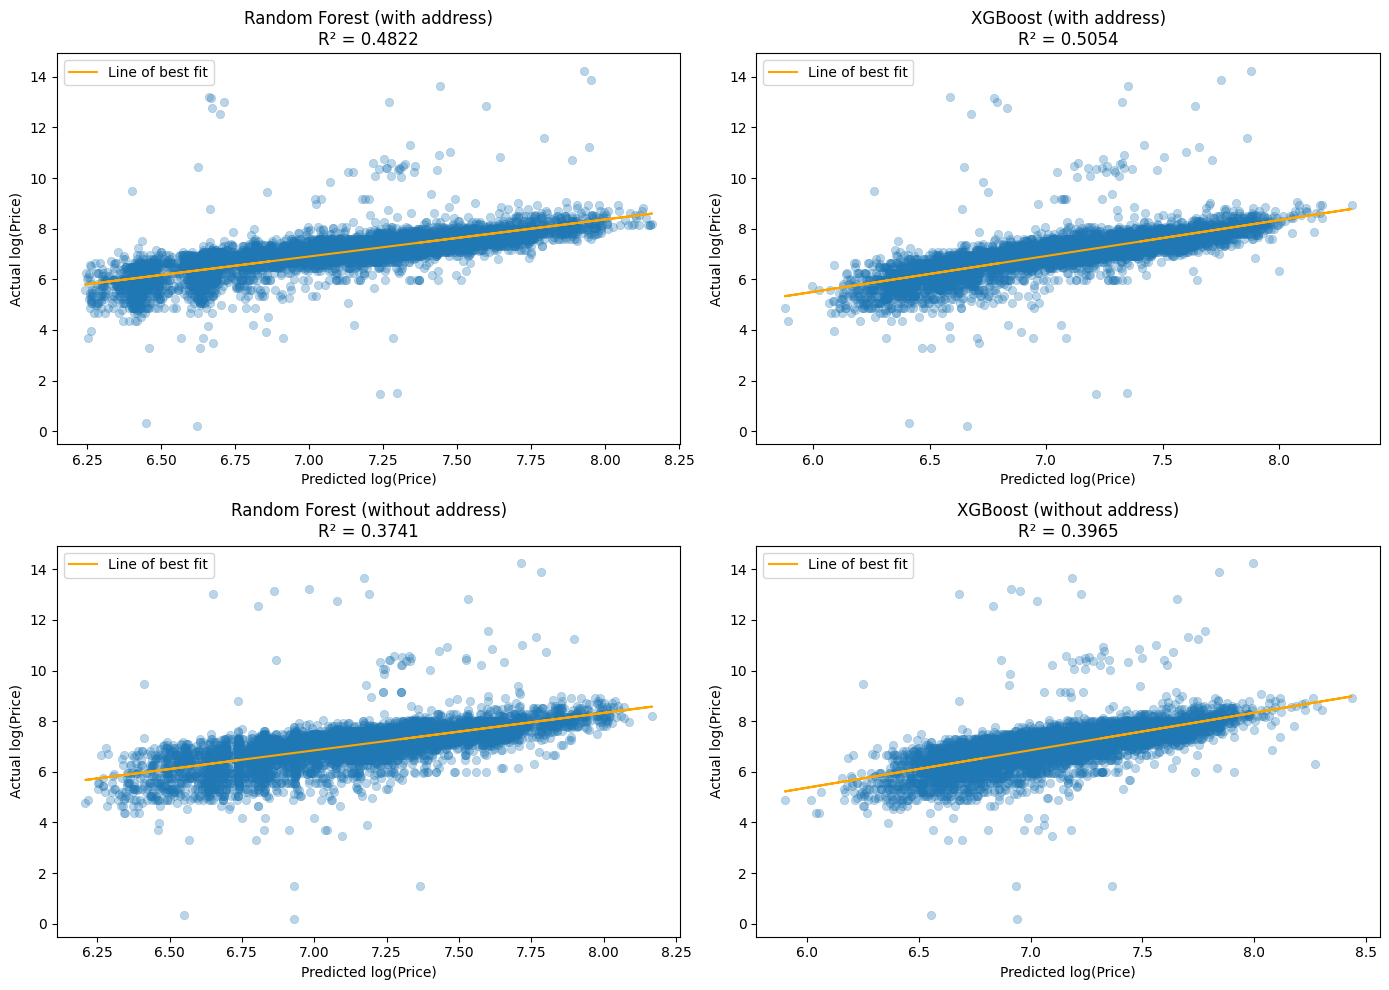

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score

# Helper to plot actual vs predicted with line of best fit
def plot_actual_vs_pred(ax, y_true, y_pred, title):
    sns.scatterplot(x=y_pred, y=y_true, ax=ax, alpha=0.3, edgecolor=None)
    z = np.polyfit(y_pred, y_true, 1)  # fit line
    p = np.poly1d(z)
    ax.plot(y_pred, p(y_pred), "orange", label="Line of best fit")
    ax.set_xlabel("Predicted log(Price)")
    ax.set_ylabel("Actual log(Price)")
    ax.set_title(title + f"\nR² = {r2_score(y_true, y_pred):.4f}")
    ax.legend()

# Predict
rfr_with_preds = model_rfr_with_address.predict(X_test_with_address)
rfr_wo_preds = model_rfr_without_address.predict(X_test_without_address)
xgb_with_preds = model_xgb_with_address.predict(X_test_with_address)
xgb_wo_preds = model_xgb_without_address.predict(X_test_without_address)

# Setup 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

plot_actual_vs_pred(axs[0, 0], y_test_with_address, rfr_with_preds, "Random Forest (with address)")
plot_actual_vs_pred(axs[0, 1], y_test_with_address, xgb_with_preds, "XGBoost (with address)")
plot_actual_vs_pred(axs[1, 0], y_test_without_address, rfr_wo_preds, "Random Forest (without address)")
plot_actual_vs_pred(axs[1, 1], y_test_without_address, xgb_wo_preds, "XGBoost (without address)")

plt.tight_layout()
plt.show()


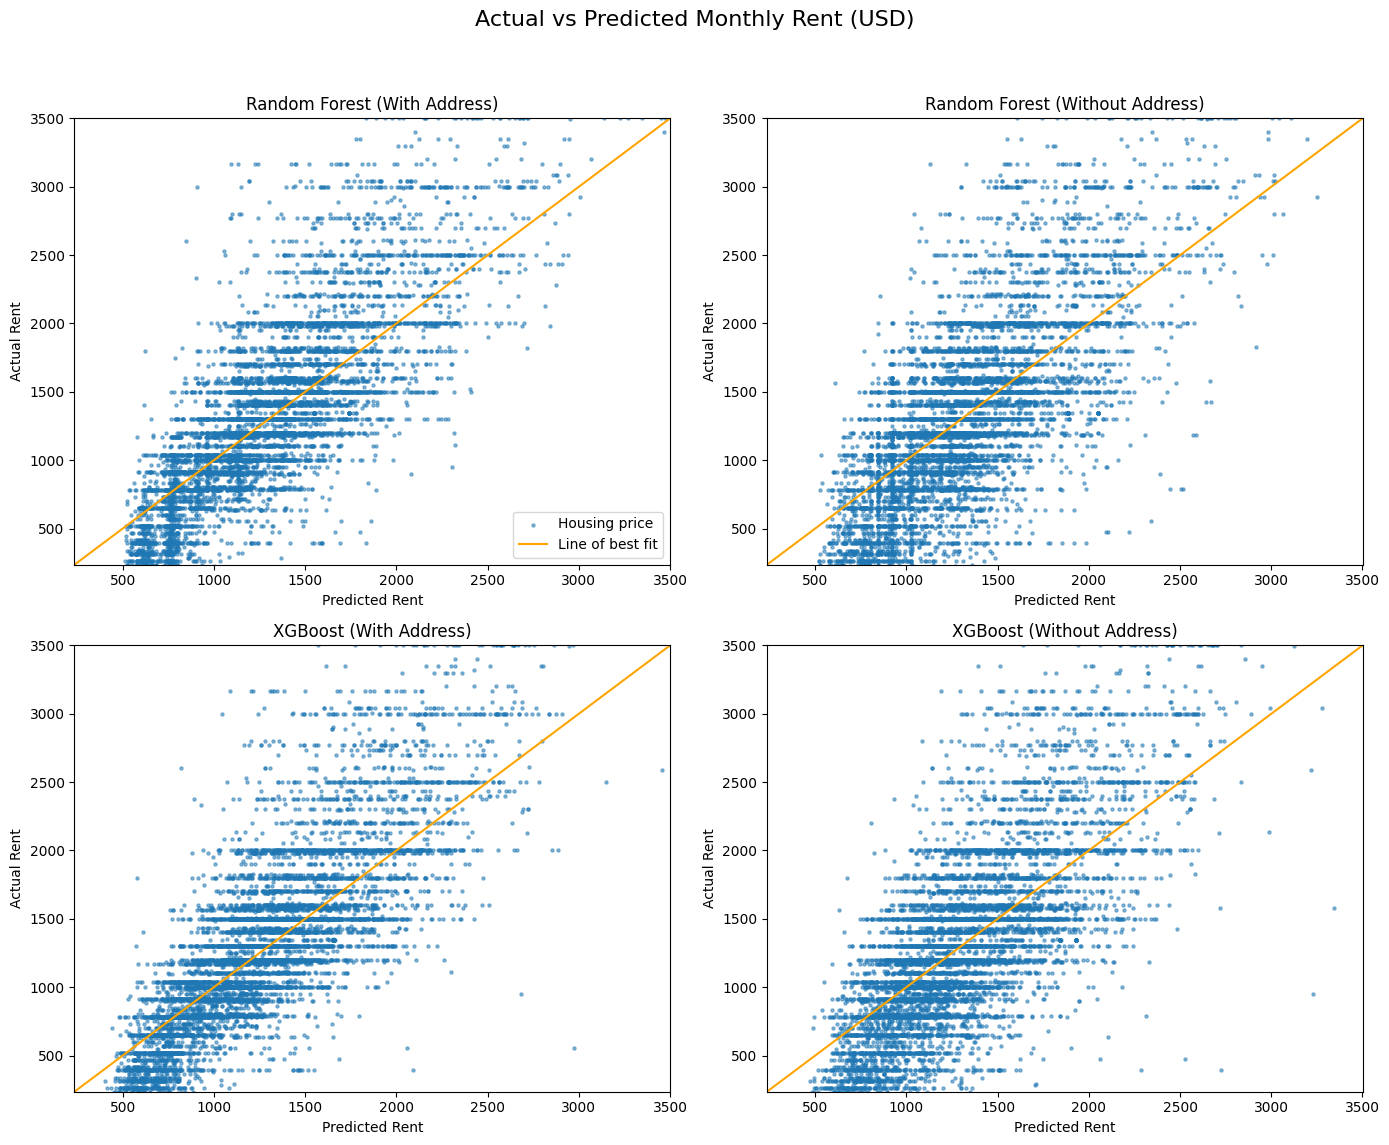

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Reverse log transformation
actual_rent_with = np.exp(y_test_with_address)
pred_rent_rfr_with = np.exp(rfr_with_preds)

actual_rent_without = np.exp(y_test_without_address)
pred_rent_rfr_without = np.exp(rfr_wo_preds)

pred_rent_xgb_with = np.exp(xgb_with_preds)
pred_rent_xgb_without = np.exp(xgb_wo_preds)

# Combine all rent values to determine 1st–99th percentile range
rent_all = np.concatenate([
    actual_rent_with, pred_rent_rfr_with,
    actual_rent_without, pred_rent_rfr_without,
    pred_rent_xgb_with, pred_rent_xgb_without
])
low, high = np.percentile(rent_all, [1, 99])  # Limit plot range

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Actual vs Predicted Monthly Rent (USD)", fontsize=16)

# --- Random Forest with address ---
axes[0, 0].scatter(pred_rent_rfr_with, actual_rent_with, s=5, alpha=0.5, label='Housing price')
axes[0, 0].plot([low, high], [low, high], 'orange', label='Line of best fit')
axes[0, 0].set_title("Random Forest (With Address)")
axes[0, 0].set_xlabel("Predicted Rent")
axes[0, 0].set_ylabel("Actual Rent")
axes[0, 0].set_xlim([low, high])
axes[0, 0].set_ylim([low, high])
axes[0, 0].legend()

# --- Random Forest without address ---
axes[0, 1].scatter(pred_rent_rfr_without, actual_rent_without, s=5, alpha=0.5)
axes[0, 1].plot([low, high], [low, high], 'orange')
axes[0, 1].set_title("Random Forest (Without Address)")
axes[0, 1].set_xlabel("Predicted Rent")
axes[0, 1].set_ylabel("Actual Rent")
axes[0, 1].set_xlim([low, high])
axes[0, 1].set_ylim([low, high])

# --- XGBoost with address ---
axes[1, 0].scatter(pred_rent_xgb_with, actual_rent_with, s=5, alpha=0.5)
axes[1, 0].plot([low, high], [low, high], 'orange')
axes[1, 0].set_title("XGBoost (With Address)")
axes[1, 0].set_xlabel("Predicted Rent")
axes[1, 0].set_ylabel("Actual Rent")
axes[1, 0].set_xlim([low, high])
axes[1, 0].set_ylim([low, high])

# --- XGBoost without address ---
axes[1, 1].scatter(pred_rent_xgb_without, actual_rent_without, s=5, alpha=0.5)
axes[1, 1].plot([low, high], [low, high], 'orange')
axes[1, 1].set_title("XGBoost (Without Address)")
axes[1, 1].set_xlabel("Predicted Rent")
axes[1, 1].set_ylabel("Actual Rent")
axes[1, 1].set_xlim([low, high])
axes[1, 1].set_ylim([low, high])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [71]:
original_test = pd.read_csv('test_translated.csv', encoding='utf-8')

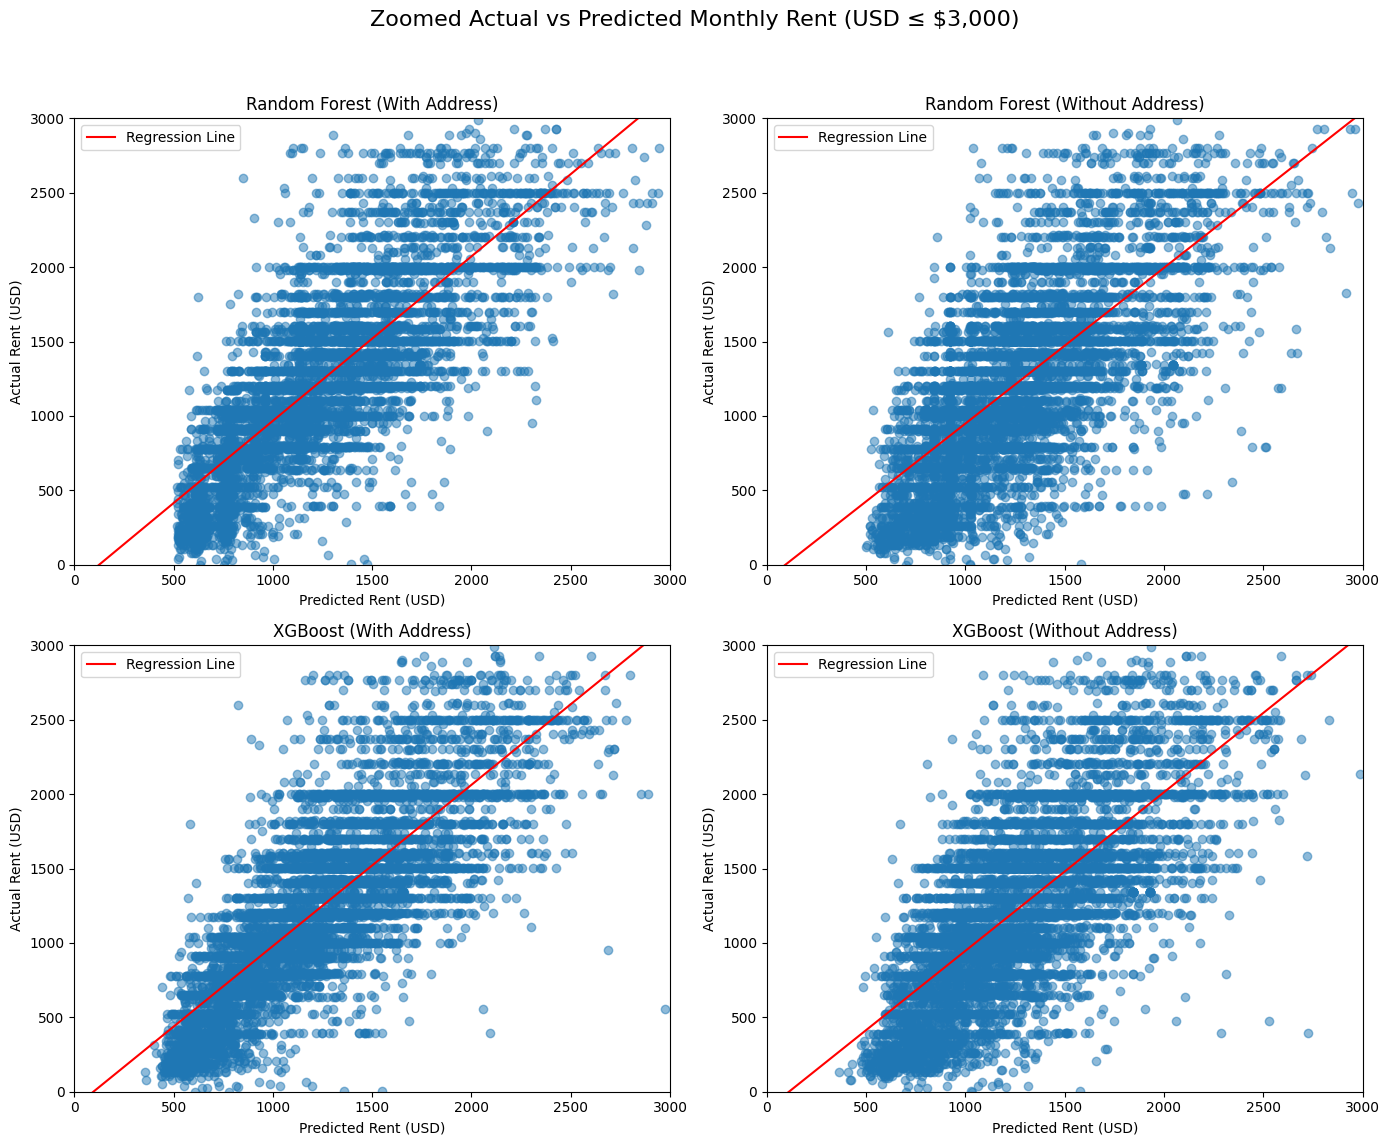

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Reverse log transformation
actual_rent_with = np.exp(y_test_with_address)
pred_rent_rfr_with = np.exp(rfr_with_preds)
pred_rent_rfr_without = np.exp(rfr_wo_preds)
pred_rent_xgb_with = np.exp(xgb_with_preds)
pred_rent_xgb_without = np.exp(xgb_wo_preds)

# Set zoom limit
zoom_limit = 3000

# Create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle("Zoomed Actual vs Predicted Monthly Rent (USD ≤ $3,000)", fontsize=16)

# Helper function to plot with true regression line
def plot_with_regression(ax, x, y, title):
    # Apply zoom filtering
    mask = (x <= zoom_limit) & (y <= zoom_limit)
    x_filtered = x[mask].reshape(-1, 1)
    y_filtered = y[mask]

    # Scatter plot
    ax.scatter(x_filtered, y_filtered, alpha=0.5)

    # Fit true regression line
    reg = LinearRegression().fit(x_filtered, y_filtered)
    x_line = np.linspace(0, zoom_limit, 100).reshape(-1, 1)
    y_line = reg.predict(x_line)

    # Plot regression line
    ax.plot(x_line, y_line, color='red', label='Regression Line')
    ax.set_xlim(0, zoom_limit)
    ax.set_ylim(0, zoom_limit)
    ax.set_title(title)
    ax.set_xlabel("Predicted Rent (USD)")
    ax.set_ylabel("Actual Rent (USD)")
    ax.legend()

# Plot each subplot with true regression line
plot_with_regression(axes[0, 0], pred_rent_rfr_with, actual_rent_with, "Random Forest (With Address)")
plot_with_regression(axes[0, 1], pred_rent_rfr_without, actual_rent_without, "Random Forest (Without Address)")
plot_with_regression(axes[1, 0], pred_rent_xgb_with, actual_rent_with, "XGBoost (With Address)")
plot_with_regression(axes[1, 1], pred_rent_xgb_without, actual_rent_without, "XGBoost (Without Address)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


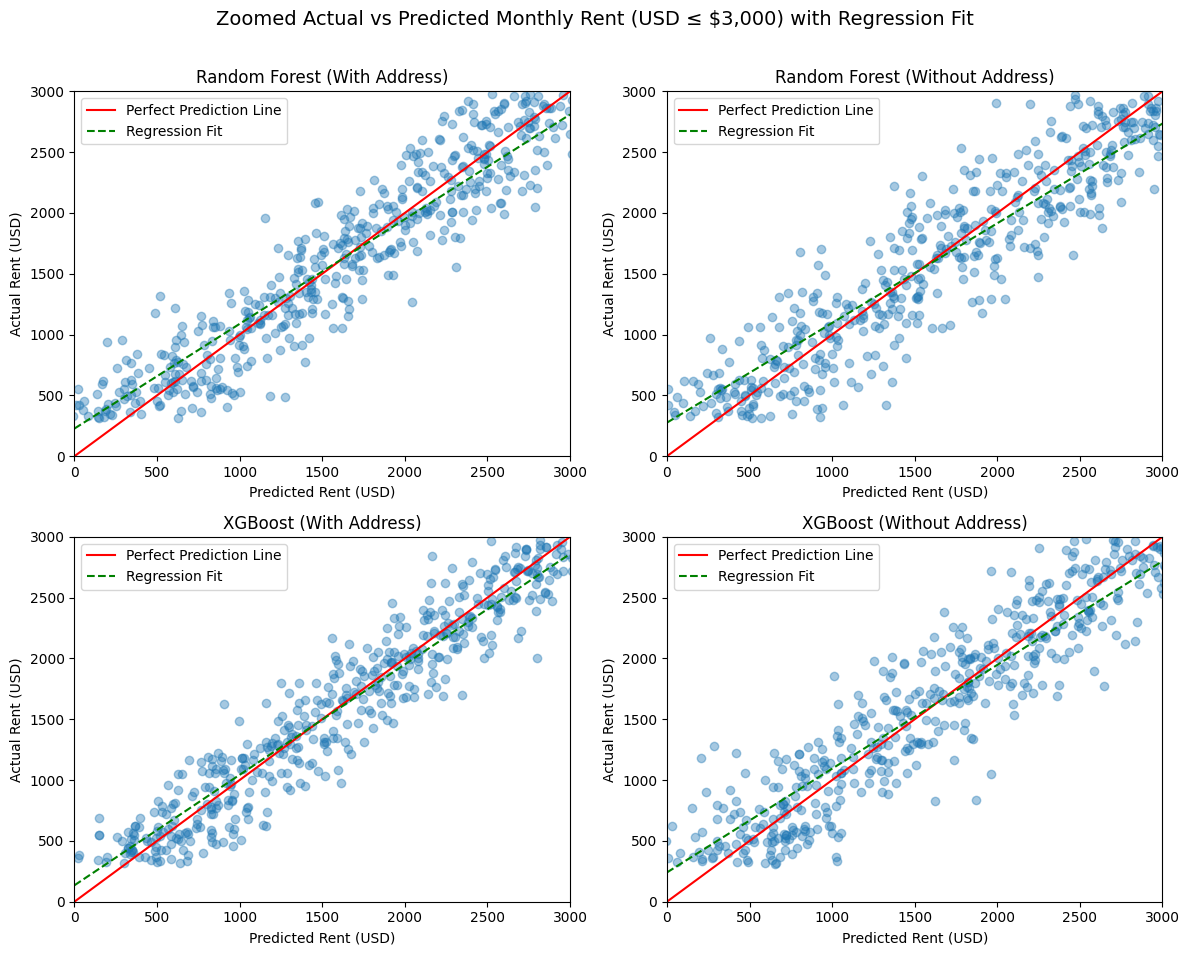

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Simulate example data (you can replace these with your actual prediction/actual values)
np.random.seed(42)
actual = np.random.uniform(300, 3000, 500)
predicted_rf_with = actual + np.random.normal(0, 300, 500)
predicted_rf_without = actual + np.random.normal(0, 350, 500)
predicted_xgb_with = actual + np.random.normal(0, 250, 500)
predicted_xgb_without = actual + np.random.normal(0, 330, 500)

# Function to create the scatter plot with fitted regression line
def plot_with_regression(ax, predicted, actual, title):
    ax.scatter(predicted, actual, alpha=0.4)
    ax.plot([0, 3000], [0, 3000], color='red', label='Perfect Prediction Line')

    # Fit a linear regression line
    model = LinearRegression()
    model.fit(predicted.reshape(-1, 1), actual)
    x_vals = np.array([0, 3000])
    y_vals = model.predict(x_vals.reshape(-1, 1))
    ax.plot(x_vals, y_vals, color='green', linestyle='--', label='Regression Fit')

    ax.set_xlim(0, 3000)
    ax.set_ylim(0, 3000)
    ax.set_xlabel('Predicted Rent (USD)')
    ax.set_ylabel('Actual Rent (USD)')
    ax.set_title(title)
    ax.legend()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_with_regression(axs[0, 0], predicted_rf_with, actual, "Random Forest (With Address)")
plot_with_regression(axs[0, 1], predicted_rf_without, actual, "Random Forest (Without Address)")
plot_with_regression(axs[1, 0], predicted_xgb_with, actual, "XGBoost (With Address)")
plot_with_regression(axs[1, 1], predicted_xgb_without, actual, "XGBoost (Without Address)")
fig.suptitle("Zoomed Actual vs Predicted Monthly Rent (USD ≤ $3,000) with Regression Fit", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


C:\Users\kelst\AppData\Local\Temp\ipykernel_57260\3010632898.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_df.head(20), palette='Blues_d')
C:\Users\kelst\AppData\Local\Temp\ipykernel_57260\3010632898.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_df.head(20), palette='Greens_d')


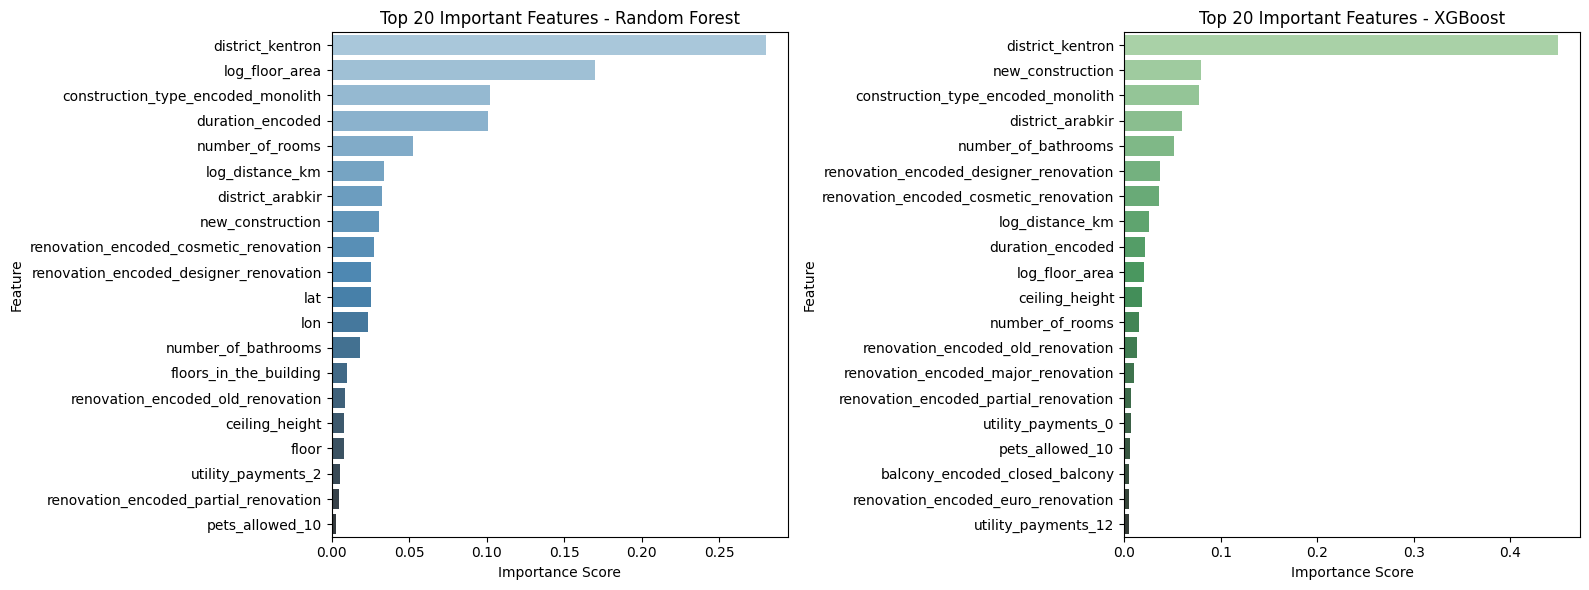

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = X_train_with_address.columns

# Extract importances
rf_importances = model_rfr_with_address.feature_importances_
xgb_importances = model_xgb_with_address.feature_importances_

# Create DataFrames
rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

xgb_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot Top 20 features for each
plt.figure(figsize=(16, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_df.head(20), palette='Blues_d')
plt.title('Top 20 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# XGBoost
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_df.head(20), palette='Greens_d')
plt.title('Top 20 Important Features - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


C:\Users\kelst\AppData\Local\Temp\ipykernel_57260\4115996971.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_df.head(20), palette='Blues_d')
C:\Users\kelst\AppData\Local\Temp\ipykernel_57260\4115996971.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_df.head(20), palette='Greens_d')


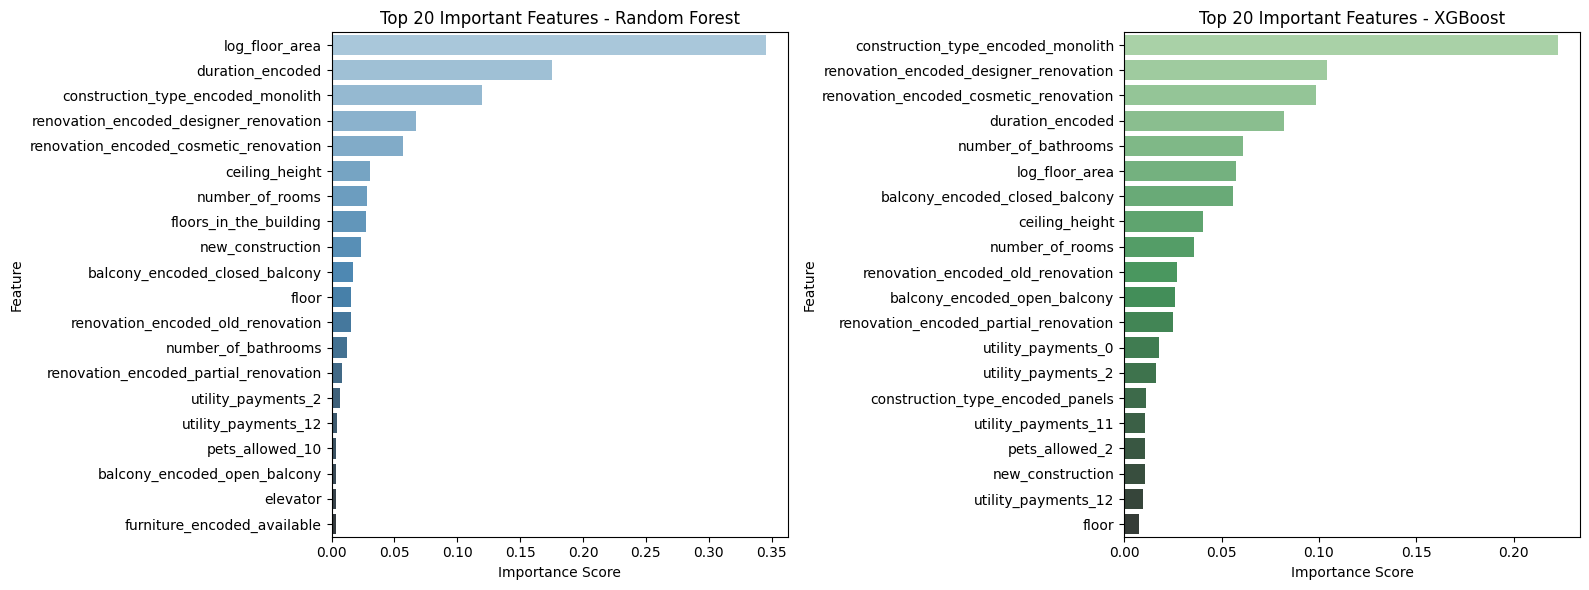

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = X_train_without_address.columns

# Extract importances
rf_importances = model_rfr_without_address.feature_importances_
xgb_importances = model_xgb_without_address.feature_importances_

# Create DataFrames
rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

xgb_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot Top 20 features for each
plt.figure(figsize=(16, 6))

# Random Forest
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=rf_df.head(20), palette='Blues_d')
plt.title('Top 20 Important Features - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# XGBoost
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=xgb_df.head(20), palette='Greens_d')
plt.title('Top 20 Important Features - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()


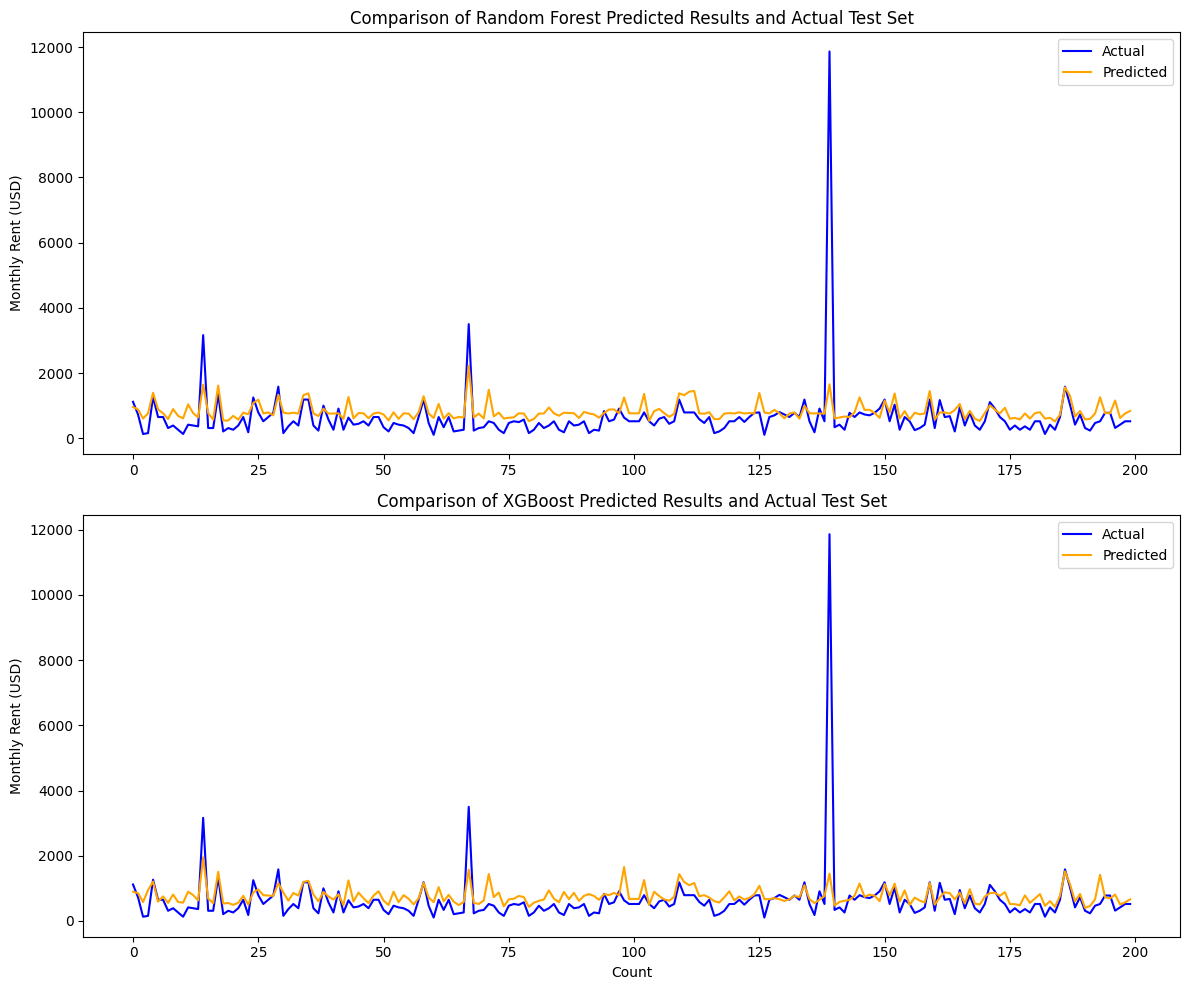

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sort to make plot lines more readable
actual_sorted = np.exp(y_test_with_address).reset_index(drop=True)
rfr_preds_sorted = np.exp(rfr_with_preds)
xgb_preds_sorted = np.exp(xgb_with_preds)

# Sort by actual value index (to keep same order)
rfr_df = pd.DataFrame({'Actual': actual_sorted, 'Predicted': rfr_preds_sorted})
xgb_df = pd.DataFrame({'Actual': actual_sorted, 'Predicted': xgb_preds_sorted})

# Limit to first 200 if needed (for clarity like the paper)
rfr_df = rfr_df.head(200)
xgb_df = xgb_df.head(200)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# RFR
axes[0].plot(rfr_df['Actual'].values, label='Actual', color='blue')
axes[0].plot(rfr_df['Predicted'].values, label='Predicted', color='orange')
axes[0].set_title('Comparison of Random Forest Predicted Results and Actual Test Set')
axes[0].set_ylabel('Monthly Rent (USD)')
axes[0].legend()

# XGBoost
axes[1].plot(xgb_df['Actual'].values, label='Actual', color='blue')
axes[1].plot(xgb_df['Predicted'].values, label='Predicted', color='orange')
axes[1].set_title('Comparison of XGBoost Predicted Results and Actual Test Set')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Monthly Rent (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()


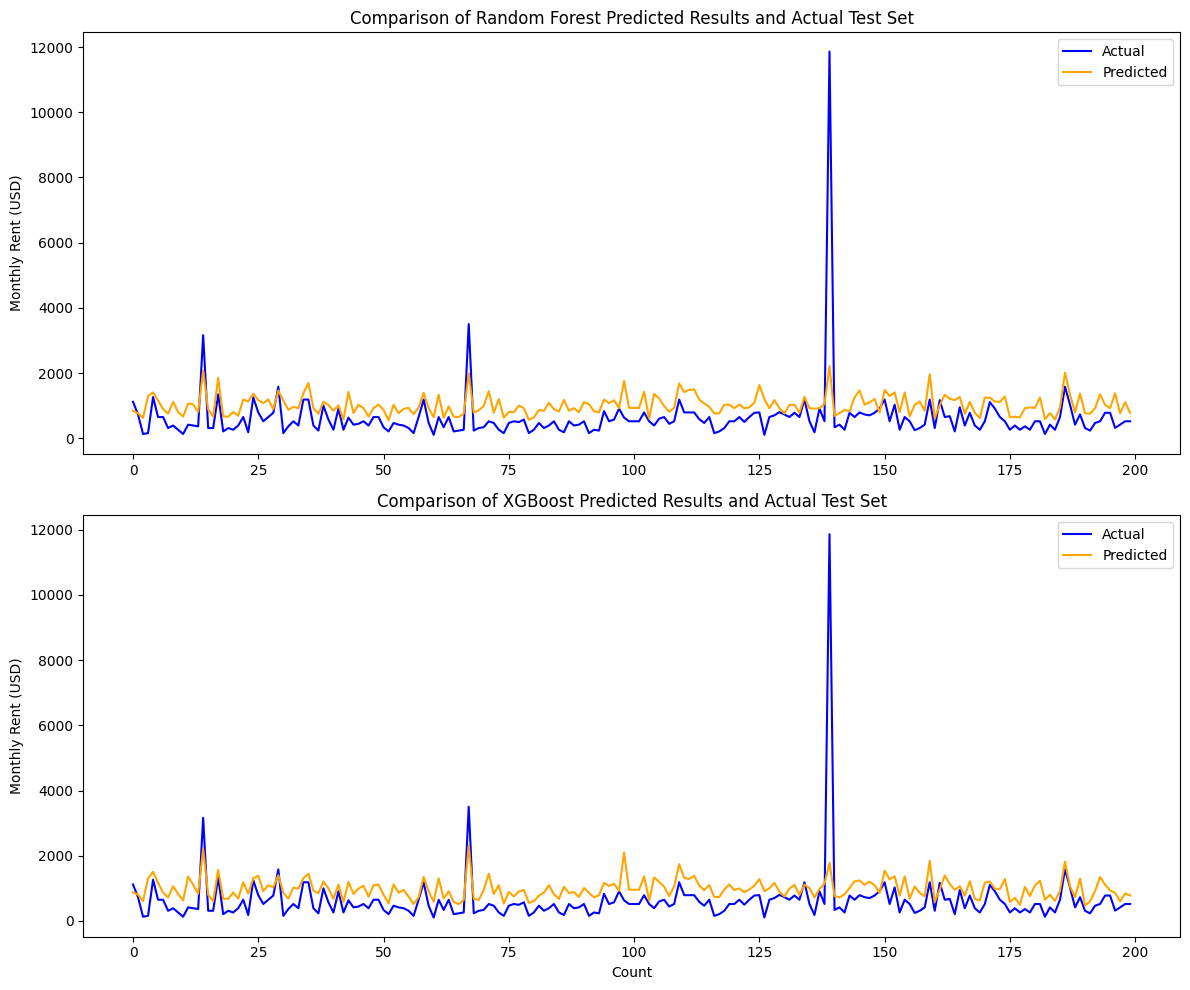

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sort to make plot lines more readable
actual_sorted = np.exp(y_test_without_address).reset_index(drop=True)
rfr_preds_sorted = np.exp(rfr_wo_preds)
xgb_preds_sorted = np.exp(xgb_wo_preds)

# Sort by actual value index (to keep same order)
rfr_df = pd.DataFrame({'Actual': actual_sorted, 'Predicted': rfr_preds_sorted})
xgb_df = pd.DataFrame({'Actual': actual_sorted, 'Predicted': xgb_preds_sorted})

# Limit to first 200 if needed (for clarity like the paper)
rfr_df = rfr_df.head(200)
xgb_df = xgb_df.head(200)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# RFR
axes[0].plot(rfr_df['Actual'].values, label='Actual', color='blue')
axes[0].plot(rfr_df['Predicted'].values, label='Predicted', color='orange')
axes[0].set_title('Comparison of Random Forest Predicted Results and Actual Test Set')
axes[0].set_ylabel('Monthly Rent (USD)')
axes[0].legend()

# XGBoost
axes[1].plot(xgb_df['Actual'].values, label='Actual', color='blue')
axes[1].plot(xgb_df['Predicted'].values, label='Predicted', color='orange')
axes[1].set_title('Comparison of XGBoost Predicted Results and Actual Test Set')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Monthly Rent (USD)')
axes[1].legend()

plt.tight_layout()
plt.show()


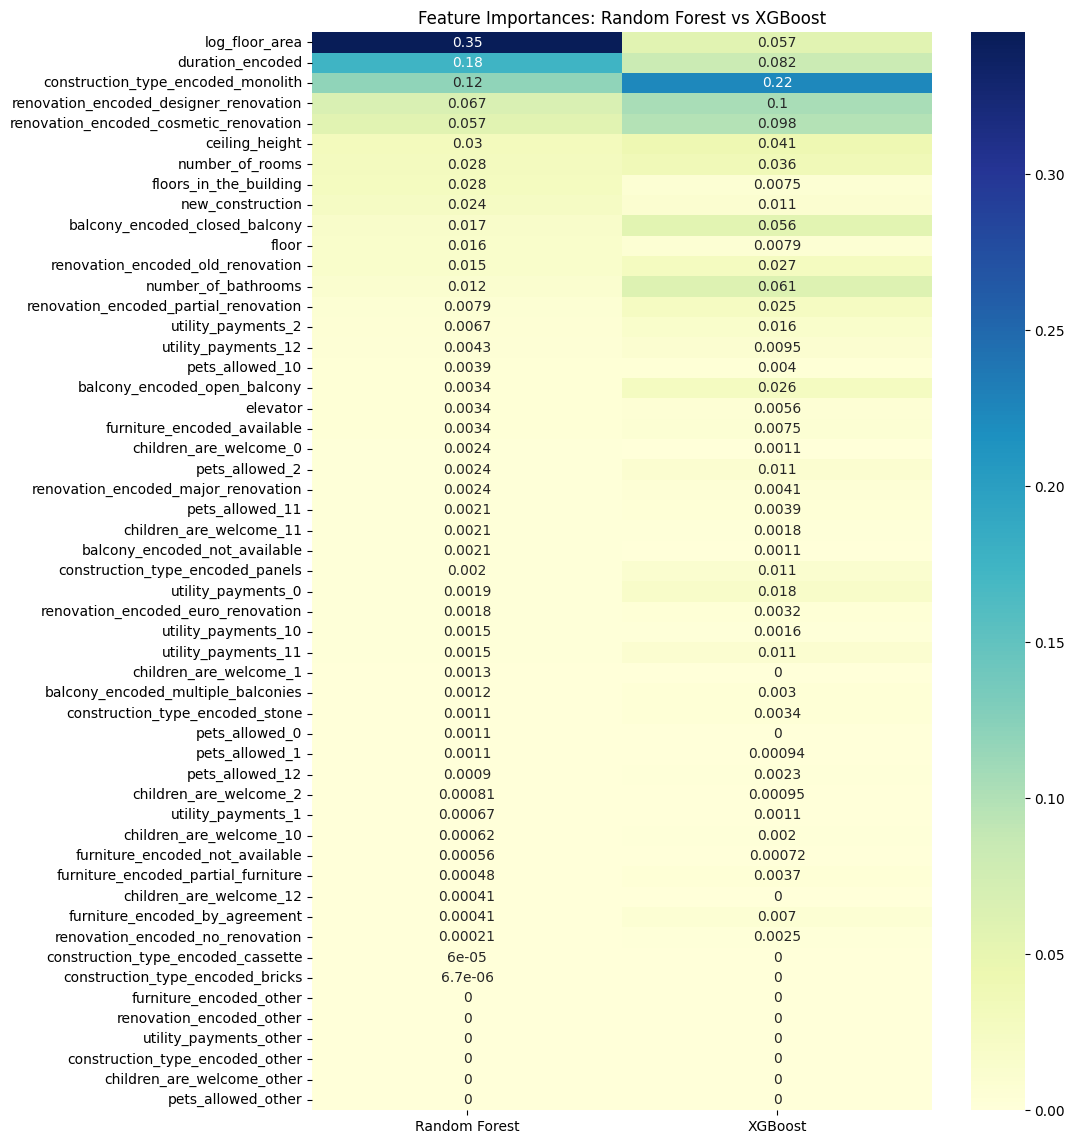

In [80]:
import pandas as pd

importance_data = pd.DataFrame({
    'Random Forest': model_rfr_without_address.feature_importances_,
    'XGBoost': model_xgb_without_address.feature_importances_
}, index=X_train.columns)

plt.figure(figsize=(10, 14))
sns.heatmap(importance_data.sort_values(by='Random Forest', ascending=False), cmap='YlGnBu', annot=True)
plt.title("Feature Importances: Random Forest vs XGBoost")
plt.show()



In [81]:
# model_xgb_without_address.get_booster().get_score(importance_type='gain')
# # or
# importance_type='weight' or 'cover'
